In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from fredapi import Fred
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")




Import all data necessary for the entire project (besides FRED data from csv)

In [2]:
start_date = "1994-01-01"
end_date = "2014-01-01"

api_key = "08e5257628ddf030304b107dd5185a26"
fred = Fred(api_key=api_key)

aapl_data = yf.download("AAPL", start=start_date, end=end_date)
bond_data_10 = yf.download("^TNX", start=start_date, end=end_date)
bond_data_5 = yf.download("^FVX", start=start_date, end=end_date)
federal_funds_data = fred.get_series("DFF", start_date=start_date, end_date=end_date)
treasury_bill_data = yf.download("^IRX", start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Preprocess the data and import in preprocessed FRED indicator data to make the dataset for the project

In [3]:
def prepare_dataset(bond_data_10, bond_data_5, treasury_bill_data, federal_funds_data):
    
    df = pd.DataFrame()
    
    start_date = "1994-01-01"
    end_date = "2014-01-01"

    date_range = pd.date_range(start=start_date, end=end_date)
    bond_data_10.reindex(date_range).ffill()
    treasury_bill_data.reindex(date_range).ffill()
    federal_funds_data.reindex(date_range).ffill()
    bond_data_5.reindex(date_range).ffill()

    bond_yield_10 = bond_data_10['Adj Close']
    treasury_bill_yield = treasury_bill_data['Adj Close']
    federal_funds_rate = federal_funds_data


    # Calculate the term spread (10-year bond yield - 3-month treasury bill yield)
    term_spread = bond_yield_10 - treasury_bill_yield

    df["10Y3Mspread"] = term_spread
    df["10Y3Mspread"] = df["10Y3Mspread"].ffill()

    bond_yield_5 = bond_data_5['Adj Close']
    term_spread = bond_yield_5 - treasury_bill_yield
    df["5Y3Mspread"] = term_spread
    df["5Y3Mspread"] = df["5Y3Mspread"].ffill()

    delta_federal_funds = federal_funds_rate.diff()
    delta_treasury_bill = treasury_bill_yield.diff()
    delta_govt_bond =  bond_yield_10.diff()

    df["delta_federal_funds"] = delta_federal_funds

    df["delta_treasury_bill"] = delta_treasury_bill 
    df["delta_treasury_bill"] = df["delta_treasury_bill"].ffill() 

    df["delta_govt_bond"] = delta_govt_bond
    df["delta_govt_bond"] = df["delta_govt_bond"].ffill() 

    
    fred_indicators = pd.read_csv("fred_indicators.csv")
    fred_indicators.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    fred_indicators = fred_indicators.set_index("Date").drop("2014-01-01")
    fred_indicators.index = pd.to_datetime(fred_indicators.index)
    df = pd.merge(df, fred_indicators, left_on = "Date", right_on = "Date")

    df = df.drop("1994-01-03", axis = 0)
    df = df.drop("FEDFUNDS", axis = 1)

    return df

Create the dataset

In [4]:
combined_dataset = prepare_dataset(bond_data_10, bond_data_5, treasury_bill_data, federal_funds_data)

Scale and PCA transform data to normalize the data and reduce dimensionality

In [5]:
scaler = StandardScaler()
combined_dataset_scaled = scaler.fit_transform(combined_dataset)


In [6]:
pca = PCA(n_components=26)
combined_dataset_pca = pca.fit_transform(combined_dataset_scaled)


Create a Scree plot to determine the optimal number of cluster to use in the K-means algorithm

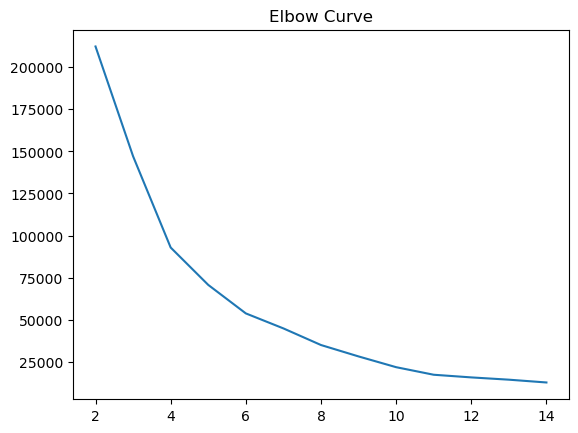

In [17]:
sp = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k, n_init=1)
    kmeans.fit(combined_dataset.values)
    sp.append(kmeans.inertia_)
plt.plot(range(2,15), sp)
plt.title("Elbow Curve")
plt.show()

Train the k-means algorithm on 3 clusters as the elbow appears to be at 3 clusters on the elbow curve

In [20]:
# kmeans = KMeans(n_clusters=3).fit(combined_dataset_pca)
# labels = kmeans.labels_
kmeans = KMeans(n_clusters=3, n_init=1).fit(combined_dataset_pca)
labels = kmeans.labels_

Get the accuracy of the predictions of several different ML algorithms on clusters to see which is best 

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import xgboost as xgb

classifiers = {
    'Linear Discriminant Analysis (LDA)': LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Support Vector Machine (SVM)': SVC(random_state=42),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
}

# Use accuracy as the scoring metric for multi-class classification
accuracy_scorer = make_scorer(accuracy_score)

for clf_name, clf in classifiers.items():
    # Perform 10-fold cross-validation
    scores = cross_val_score(clf, combined_dataset_pca, labels, cv=10, scoring=accuracy_scorer)
    # Print the mean accuracy score
    print(f"{clf_name} - Mean Accuracy: {scores.mean()}")



Linear Discriminant Analysis (LDA) - Mean Accuracy: 0.931602134376665
Logistic Regression - Mean Accuracy: 0.9742892700654469
AdaBoost Classifier - Mean Accuracy: 0.9414159728352061
Naive Bayes - Mean Accuracy: 0.7399229429587041
Random Forest Classifier - Mean Accuracy: 0.977873336991356
Support Vector Machine (SVM) - Mean Accuracy: 0.9519641990918561
K-Nearest Neighbors (KNN) - Mean Accuracy: 0.8955570929853442
Decision Tree Classifier - Mean Accuracy: 0.9679135752399584


Take the classifier with the highest accuracy and use that for predictions in the future and for backtesting


In [22]:
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(combined_dataset_pca, labels)

Prepare the dataset to be input into the XGBRegressor model (Can use different models)

In [23]:
combined_dataset["Regime"] = labels

In [24]:
def prepare_dataset_for_prediction(data, aapl_data):
    data["Close"] = aapl_data["Close"]
    return data

In [25]:
prediction_data = prepare_dataset_for_prediction(combined_dataset, aapl_data)

Create 3 separate datsets for training separated by regime

In [26]:
prediction_data_0 = prediction_data[prediction_data['Regime'] == 0]
prediction_data_1 = prediction_data[prediction_data['Regime'] == 1]
prediction_data_2 = prediction_data[prediction_data['Regime'] == 2]

Create and fit the XGB Regressor models on the 3 datasets

In [27]:
model_regime_0 = XGBRegressor(random_state = 42)
model_regime_0.fit(prediction_data_0.drop(['Regime', "Close"], axis=1), prediction_data_0['Close'])

model_regime_1 = XGBRegressor(random_state = 42)
model_regime_1.fit(prediction_data_1.drop(['Regime', "Close"], axis=1), prediction_data_1['Close'])

model_regime_2 = XGBRegressor(random_state = 42)
model_regime_2.fit(prediction_data_2.drop(['Regime', "Close"], axis=1), prediction_data_2['Close'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Create and fit the XGB Regressor Model on the entire dataset

In [28]:
model_regime_combined = XGBRegressor(random_state = 42)
model_regime_combined.fit(prediction_data.drop(['Regime', "Close"], axis=1), prediction_data['Close'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Backtest the strategy on the combined model with no regime distinction

In [32]:
import numpy as np
import pandas as pd
import vectorbt as vbt

# Clustering Model
cluster_model = clf

# Data
df = prediction_data.drop("Regime", axis = 1)

# Placeholder for entry and exit signals
df['Entry'] = np.nan
df['Exit'] = np.nan

for i in range(len(df)):
    prediction = model_regime_combined.predict(df.iloc[i].drop(['Close', 'Entry', 'Exit']).values.reshape(1, -1))
    
    
    # If the predicted future price is 0.5% higher, enter a long position
    if prediction[0] > df['Close'].iloc[i] * 1.005:
        df['Entry'].iloc[i] = True
        df['Exit'].iloc[i] = False
    # If the predicted future price is 0.3% lower, exit the long position
    elif prediction[0] < df['Close'].iloc[i] * 0.997:
        df['Exit'].iloc[i] = True
        df['Entry'].iloc[i] = False
    else:
        df['Entry'].iloc[i] = df['Exit'].iloc[i] = False

# Forward fill the signals
df['Entry'].ffill(inplace=True)
df['Exit'].ffill(inplace=True)

# Convert the signals to boolean values
df['Entry'] = df['Entry'].astype(np.bool)
df['Exit'] = df['Exit'].astype(np.bool)

portfolio = vbt.Portfolio.from_signals(df['Close'], df['Entry'], df['Exit'])

# Print the total return of the strategy
print(f"Cumulative Returns: {portfolio.total_return()}")
print(f"Sharpe Ratio: {portfolio.sharpe_ratio(freq = 'D', risk_free=0.0)}")
print(f"Annualized Returns: {portfolio.annualized_return(freq = 'D')}")





Cumulative Returns: 25361165.253788278
Sharpe Ratio: 3.067644634844744
Annualized Returns: 2.4567889528529223


Backtest the strategy on the 3 separate models with regime distinction

In [46]:
import pandas as pd
import numpy as np
import vectorbt as vbt

# Clustering Model
cluster_model = clf

# Data
df1 = prediction_data.drop("Regime", axis = 1)

# Placeholder for entry and exit signals
df1['Entry'] = np.nan
df1['Exit'] = np.nan
df1['Regime'] = np.nan

for i in range(len(df1)):
    # Use your clustering model to determine the regime
    # regime = cluster_model.predict(combined_dataset_pca[i].reshape(1, -1))
    regime = cluster_model.predict(combined_dataset_pca[i].reshape(1, -1))
    
    df1['Regime'].iloc[i] = regime

    # Use the appropriate model to predict the next price based on the regime
    if regime == 0:
        prediction = model_regime_0.predict(df1.iloc[i].drop(['Regime', 'Close', 'Entry', 'Exit']).values.reshape(1,-1))
    elif regime == 1:
        prediction = model_regime_1.predict(df1.iloc[i].drop(['Regime', 'Close', 'Entry', 'Exit']).values.reshape(1,-1))
    else:
        prediction = model_regime_2.predict(df1.iloc[i].drop(['Regime', 'Close', 'Entry', 'Exit']).values.reshape(1,-1))

    # If the predicted future price is 0.5% higher, enter a long position
    if prediction[0] > df1['Close'].iloc[i] * 1.005:
        df1['Entry'].iloc[i] = True
        df1['Exit'].iloc[i] = False
    # If the predicted future price is 0.3% lower, exit the long position
    elif prediction[0] < df1['Close'].iloc[i] * 0.997:
        df1['Exit'].iloc[i] = True
        df1['Entry'].iloc[i] = False
    else:
        df1['Entry'].iloc[i] = df1['Exit'].iloc[i] = False

# Forward fill the signals
df1['Entry'].ffill(inplace=True)
df1['Exit'].ffill(inplace=True)

# Convert the signals to boolean values
df1['Entry'] = df1['Entry'].astype(np.bool)
df1['Exit'] = df1['Exit'].astype(np.bool)

# Create the Portfolio from the signals
portfolio1 = vbt.Portfolio.from_signals(df1['Close'], df1['Entry'], df1['Exit'])

# Print the total return of the strategy
print(f"Cumulative Returns: {portfolio1.total_return()}")
print(f"Sharpe Ratio: {portfolio1.sharpe_ratio(freq = 'D', risk_free=0.0)}")
print(f"Annualized Returns: {portfolio1.annualized_return(freq = 'D')}")

print(f"Difference in Cumulative Returns between regime and no regime: {portfolio1.total_return() - portfolio.total_return()}")
print(f"Difference in Sharpe Ratio between regime and no regime: {portfolio1.sharpe_ratio(freq = 'D', risk_free=0.0) - portfolio.sharpe_ratio(freq = 'D', risk_free=0.0)}")
print(f"Difference in Annualized Returns between regime and no regime: {portfolio1.annualized_return(freq = 'D') - portfolio.annualized_return(freq = 'D')}")


Cumulative Returns: 291416353.98664975
Sharpe Ratio: 3.8453407782357956
Annualized Returns: 3.1287229633652114
Difference in Cumulative Returns between regime and no regime: 266055188.73286146
Difference in Sharpe Ratio between regime and no regime: 0.7776961433910516
Difference in Annualized Returns between regime and no regime: 0.6719340105122891


Test a bench mark buy and hold strategy to compare results

In [45]:
close = prediction_data['Close']

entry = pd.Series(False, index=close.index)
exit = pd.Series(False, index=close.index)

entry.iloc[0] = True  
exit.iloc[-1] = True  

benchmark_portfolio = vbt.Portfolio.from_signals(close, entry, exit)

print(f"Benchmark Cumulative Returns: {benchmark_portfolio.total_return()}")

portfolio_return = portfolio1.total_return()
benchmark_return = benchmark_portfolio.total_return()

print(f"Excess Return: {portfolio_return - benchmark_return}")




Benchmark Cumulative Returns: 70.24063449435764
Excess Return: 291416283.74601525
